In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Ipl Data Analysis').getOrCreate()
spark

In [2]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, DecimalType, BooleanType, DateType
from pyspark.sql.functions import col, when, sum, avg, row_number
from pyspark.sql.window import Window


ball_by_ball_Schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

ball_by_ball_df = spark.read.csv('Ball_By_Ball.csv',header=True,schema=ball_by_ball_Schema)

In [3]:
match_Schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.csv('Match.csv',header=True,schema=match_Schema)

In [4]:
player_Schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])
player_df = spark.read.csv('Player.csv',header=True,schema=player_Schema)

In [5]:
player_match_Schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])
player_match_df = spark.read.csv('Player_match.csv',header=True,schema=player_match_Schema)

In [6]:
team_Schema = StructType([
    StructField("team_sk",IntegerType(),True),
    StructField("team_id",IntegerType(),True),
    StructField("team_name",StringType(),True)
])
team_df = spark.read.csv('Team.csv',header=True,schema=team_Schema)

In [7]:
# Filter to include only valid deliveries 
# (excluding extras like wides and no balls for specific analyses)
ball_by_ball_df = ball_by_ball_df.filter((col('wides')==0) & (col('noballs')==0))

# Aggregation: Calculate the total and average runs scored in each match and inning
total_and_avg_runs = ball_by_ball_df.groupBy('match_id','innings_no').agg(
        sum('runs_scored').alias('total_runs'),
        avg('runs_scored').alias('average_runs')
)


In [8]:
# Window Function: Calculate running total of runs in each match for each over
windowSpec = Window.partitionBy("match_id","innings_no").orderBy("over_id")

ball_by_ball_df = ball_by_ball_df.withColumn(
        "running_total_runs",
         sum("runs_scored").over(windowSpec)
)

In [11]:
# Conditional Column : Flag for high impact balls (either a wicket or more than 6 runs including extras)
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_impact",
    when((col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket")==True), True).otherwise(False)
)

In [12]:
ball_by_ball_df.show(3)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+------------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out| lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|

In [13]:
from pyspark.sql.functions import year, month, dayofmonth, when

# Extracting year, month, and day from the match date for more detailed time-based analysis
match_df = match_df.withColumn("year", year("match_date"))
match_df = match_df.withColumn("month", month("match_date"))
match_df = match_df.withColumn("day",dayofmonth("match_date"))

# High Margin wins categorizing win margins into 'high', 'medium' and 'low'
match_df = match_df.withColumn(
        "win_margin_category",
         when(col("win_margin") >= 100, "High")
         .when((col("win_margin") >= 50) & (col("win_margin") < 100), "Medium")
         .otherwise("Low")
)

# Analyze the impact of the toss: who wins the toss and the match
match_df = match_df.withColumn(
            "toss_match_winner",
             when(col("toss_winner") == col("match_winner"), "Yes").otherwise("No")
)

# Show the enhanced match DataFrame
match_df.show(2)

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+----+-----+----+-------------------+-----------------+
|match_sk|match_id|               team1|               team2|match_date|season_year|          venue_name| city_name|country_name|         toss_winner|        match_winner|toss_name|win_type|outcome_type|  manofmach|win_margin|country_id|year|month| day|win_margin_category|toss_match_winner|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+----+-----+----+-------------------+-----------------+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...|      NULL|       2008|M Chinnaswamy Sta...| Bangalore|       I

In [14]:
from pyspark.sql.functions import lower, regexp_replace

# Normalize and clean player names
player_df = player_df.withColumn("player_name", lower(regexp_replace("player_name", "[^a-zA-Z0-9 ]", "")))

# Handle missing values in 'batting_hand' and 'bowling_skill' with a default 'unknown'
player_df = player_df.na.fill({"batting_hand": "unknown", "bowling_skill": "unknown"})

# Categorizing players based on batting hand
player_df = player_df.withColumn(
    "batting_style",
    when(col("batting_hand").contains("left"), "Left-Handed").otherwise("Right-Handed")
)

# Show the modified player DataFrame
player_df.show(2)

+---------+---------+-----------+----+--------------+----------------+------------+-------------+
|player_sk|player_id|player_name| dob|  batting_hand|   bowling_skill|country_name|batting_style|
+---------+---------+-----------+----+--------------+----------------+------------+-------------+
|        0|        1| sc ganguly|NULL| Left-hand bat|Right-arm medium|       India| Right-Handed|
|        1|        2|bb mccullum|NULL|Right-hand bat|Right-arm medium| New Zealand| Right-Handed|
+---------+---------+-----------+----+--------------+----------------+------------+-------------+
only showing top 2 rows



In [16]:
from pyspark.sql.functions import col, when, current_date, expr

# Add a 'veteran_status' column based on player age
player_match_df = player_match_df.withColumn(
    "veteran_status",
    when(col("age_as_on_match") >= 35, "Veteran").otherwise("Non-Veteran")
)

# Dynamic column to calculate years since debut
player_match_df = player_match_df.withColumn(
    "years_since_debut",
    (year(current_date()) - col("season_year"))
)

# Show the enriched DataFrame
player_match_df.show(2)


+---------------+---------------+--------+---------+-----------+----+--------------+------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+--------------+-----------------+
|player_match_sk|playermatch_key|match_id|player_id|player_name| dob|  batting_hand|     bowling_skill|country_name|role_desc|         player_team|        opposit_team|season_year|is_manofthematch|age_as_on_match|isplayers_team_won|batting_status|bowling_status|player_captain|opposit_captain|player_keeper|opposit_keeper|veteran_status|years_since_debut|
+---------------+---------------+--------+---------+-----------+----+--------------+------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+-----------

In [18]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [19]:
top_scoring_batsmen_per_season = spark.sql("""
SELECT 
p.player_name,
m.season_year,
SUM(b.runs_scored) AS total_runs
FROM 
ball_by_ball b 
JOIN match m ON b.match_id = m.match_id
JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON p.player_id = pm.player_id
GROUP BY p.player_name, m.season_year
ORDER BY m.season_year, total_runs DESC
""")

In [24]:
economical_bowlers_powerplay = spark.sql("""
SELECT
p.player_name, AVG(b.runs_scored) AS avg_runs_per_ball, COUNT(b.bowler_wicket) AS total_wickets
FROM ball_by_ball b 
JOIN player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) > 1
ORDER BY avg_runs_per_ball, total_wickets DESC
""")

In [26]:
toss_impact_individual_matches = spark.sql("""
SELECT m.match_id, m.toss_winner, m.toss_name, m.match_winner,
    CASE WHEN m.toss_winner = m.match_winner THEN 'WON' ELSE 'Lost' END AS match_outcome
FROM match m
WHERE m.toss_name IS NOT NULL
ORDER BY m.match_id
""")
toss_impact_individual_matches.show()

+--------+--------------------+---------+--------------------+-------------+
|match_id|         toss_winner|toss_name|        match_winner|match_outcome|
+--------+--------------------+---------+--------------------+-------------+
|  335987|Royal Challengers...|    field|Kolkata Knight Ri...|         Lost|
|  335988| Chennai Super Kings|      bat| Chennai Super Kings|          WON|
|  335989|    Rajasthan Royals|      bat|    Delhi Daredevils|         Lost|
|  335990|      Mumbai Indians|      bat|Royal Challengers...|         Lost|
|  335991|     Deccan Chargers|      bat|Kolkata Knight Ri...|         Lost|
|  335992|     Kings XI Punjab|      bat|    Rajasthan Royals|         Lost|
|  335993|     Deccan Chargers|      bat|    Delhi Daredevils|         Lost|
|  335994|      Mumbai Indians|    field| Chennai Super Kings|         Lost|
|  335995|    Rajasthan Royals|    field|    Rajasthan Royals|          WON|
|  335996|      Mumbai Indians|    field|     Kings XI Punjab|         Lost|

In [27]:
average_runs_in_wins = spark.sql("""
SELECT p.player_name, AVG(b.runs_scored) AS avg_runs_in_wins, COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_runs_in_wins ASC
""")
average_runs_in_wins.show()

+--------------+-------------------+--------------+
|   player_name|   avg_runs_in_wins|innings_played|
+--------------+-------------------+--------------+
|    kp appanna|                0.0|             1|
|     jj bumrah|                0.0|             2|
|      i sharma|                0.0|             1|
|      j theron|                0.0|             1|
|      ts mills|                0.0|             3|
|      vr aaron|                0.0|             5|
|       a nehra|                0.0|             2|
|     sn thakur|                0.0|             2|
| anirudh singh|                0.0|             1|
|    t thushara|                0.2|             5|
|     sa abbott|               0.25|             4|
| yashpal singh| 0.3157894736842105|            19|
|   s sreesanth| 0.3333333333333333|             3|
|   kc cariappa| 0.3333333333333333|             3|
|    jd unadkat|                0.4|             5|
|    sm harwood|0.42857142857142855|             7|
|       jm k

Matplotlib is building the font cache; this may take a moment.


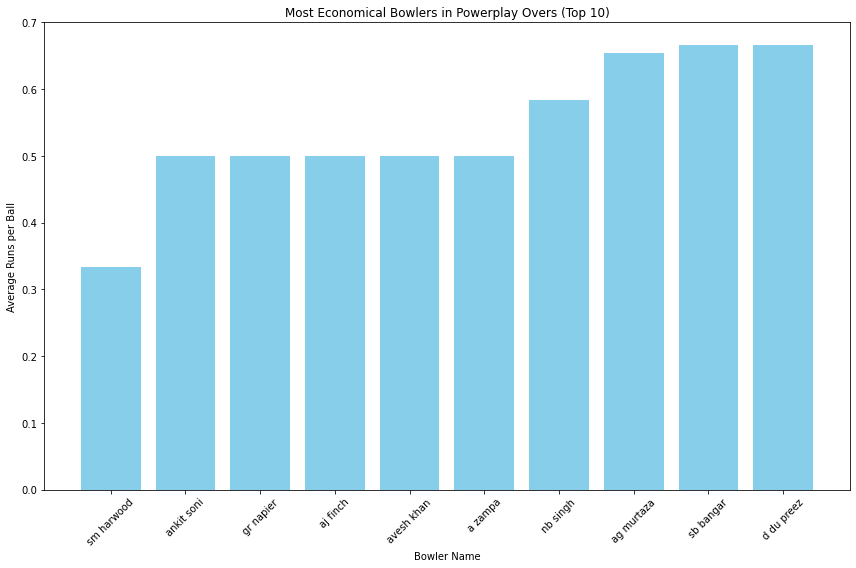

In [28]:
import matplotlib.pyplot as plt

# Assuming 'economical_bowlers_powerplay' is already executed and available as a Spark DataFrame
economical_bowlers_pd = economical_bowlers_powerplay.toPandas()

# Visualizing using Matplotlib
plt.figure(figsize=(12, 8))
# Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.nsmallest(10, 'avg_runs_per_ball')
plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['avg_runs_per_ball'], color='skyblue')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

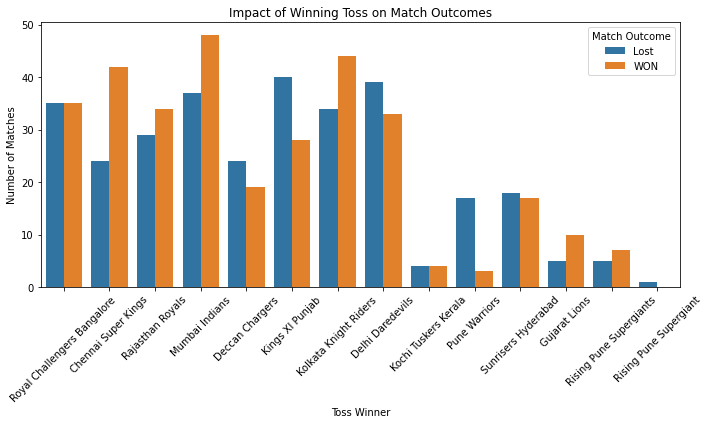

In [29]:
import seaborn as sns

toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(10, 6))
sns.countplot(x='toss_winner', hue='match_outcome', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

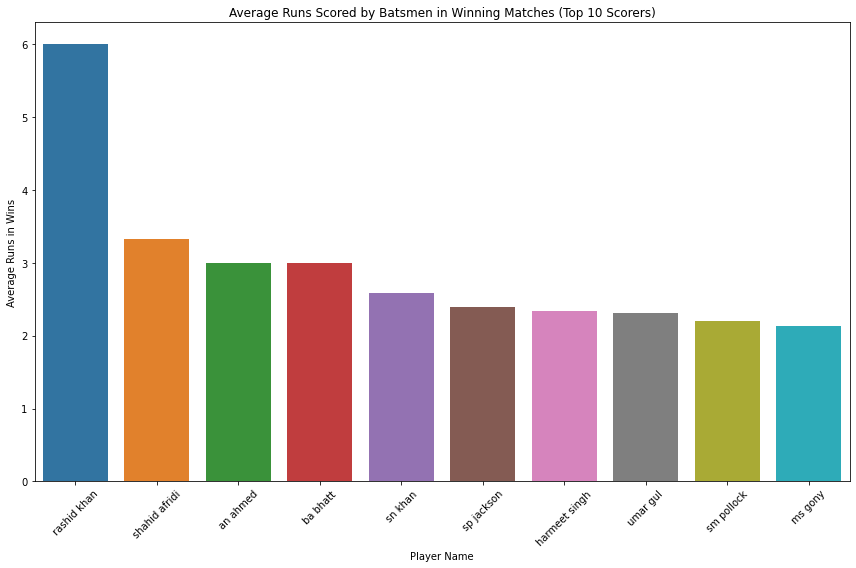

In [30]:
average_runs_pd = average_runs_in_wins.toPandas()

# Using seaborn to plot average runs in winning matches
plt.figure(figsize=(12, 8))
top_scorers = average_runs_pd.nlargest(10, 'avg_runs_in_wins')
sns.barplot(x='player_name', y='avg_runs_in_wins', data=top_scorers)
plt.title('Average Runs Scored by Batsmen in Winning Matches (Top 10 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Average Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Execute SQL Query
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")

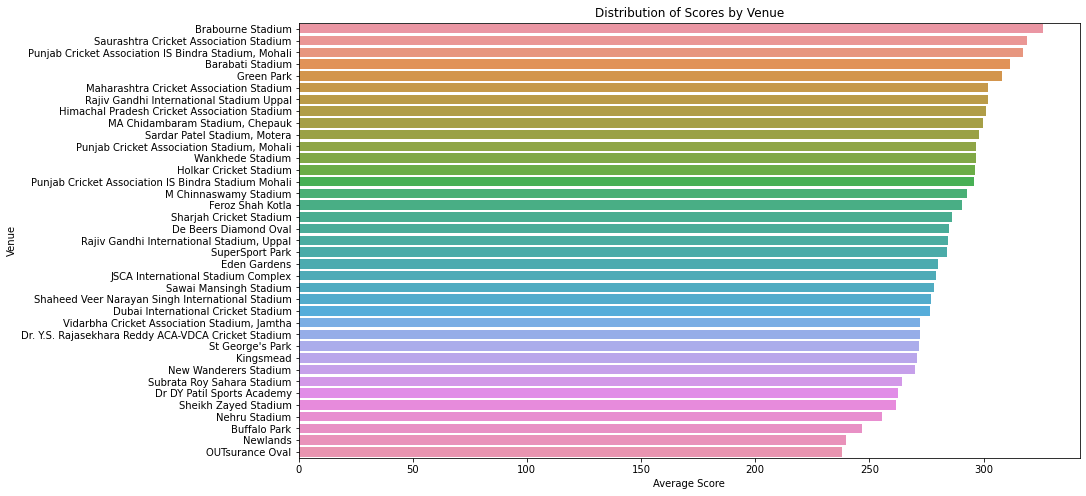

In [32]:
# Convert to Pandas DataFrame
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='average_score', y='venue_name', data=scores_by_venue_pd)
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

In [34]:
# Execute SQL Query
dismissal_types = spark.sql("""
SELECT out_type, COUNT(*) AS frequency
FROM ball_by_ball
WHERE out_type IS NOT NULL
GROUP BY out_type
ORDER BY frequency DESC
""")
dismissal_types.show()

+--------------------+---------+
|            out_type|frequency|
+--------------------+---------+
|      Not Applicable|   137852|
|              caught|     3678|
|              bowled|     1382|
|             run out|      744|
|        Keeper Catch|      695|
|                 lbw|      455|
|             stumped|      222|
|   caught and bowled|      211|
|          hit wicket|        9|
|        retired hurt|        9|
|obstructing the f...|        1|
+--------------------+---------+



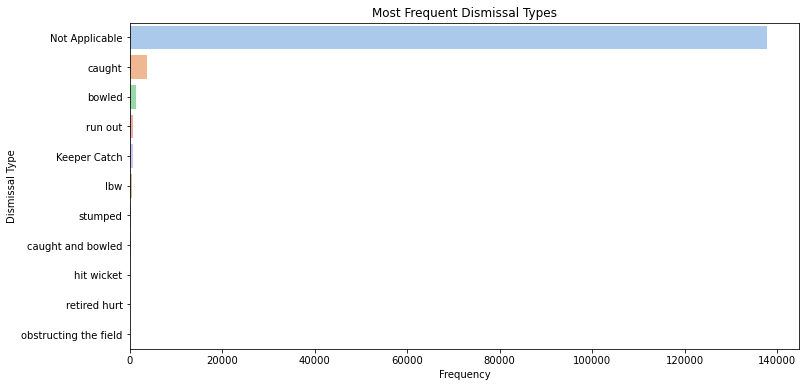

In [35]:
# Convert to Pandas DataFrame
dismissal_types_pd = dismissal_types.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='out_type', data=dismissal_types_pd, palette='pastel')
plt.title('Most Frequent Dismissal Types')
plt.xlabel('Frequency')
plt.ylabel('Dismissal Type')
plt.show()

In [37]:
# Execute SQL Query
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")
team_toss_win_performance.show()

+--------------------+--------------+---------------+
|               team1|matches_played|wins_after_toss|
+--------------------+--------------+---------------+
| Chennai Super Kings|            37|             27|
|      Mumbai Indians|            42|             26|
|Kolkata Knight Ri...|            36|             24|
|Royal Challengers...|            34|             19|
|    Delhi Daredevils|            36|             17|
|    Rajasthan Royals|            25|             16|
|     Kings XI Punjab|            32|             14|
| Sunrisers Hyderabad|            16|              8|
|     Deccan Chargers|            22|              6|
|Rising Pune Super...|             6|              4|
|       Gujarat Lions|             7|              3|
|Kochi Tuskers Kerala|             4|              2|
|       Pune Warriors|            10|              2|
+--------------------+--------------+---------------+



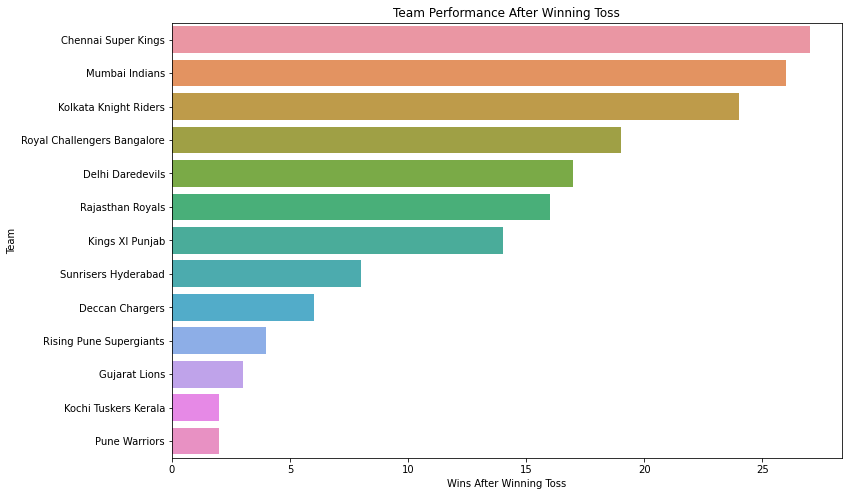

In [38]:
# Convert to Pandas DataFrame
team_toss_win_pd = team_toss_win_performance.toPandas()

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='wins_after_toss', y='team1', data=team_toss_win_pd)
plt.title('Team Performance After Winning Toss')
plt.xlabel('Wins After Winning Toss')
plt.ylabel('Team')
plt.show()